In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import Normal
from scipy.linalg import block_diag
from numpy.linalg import inv
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs, num_units):
    
    def normal(shape):
        return Variable(nn.Parameter(torch.randn(size = shape))) * 0.01
    def zero(shape):
        return Variable(nn.Parameter(torch.zeros(shape)))
    def three(num_inputs, num_hiddens, num_outputs):
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), zero(num_hiddens))
    
    W_xi, W_hi, b_i = three(num_inputs, num_hiddens, num_outputs) # 输入门参数
    W_xf, W_hf, b_f = three(num_inputs, num_hiddens, num_outputs) # 遗忘门参数
    W_xo, W_ho, b_o = three(num_inputs, num_hiddens, num_outputs) # 输出门参数
    W_xc, W_hc, b_c = three(num_inputs, num_hiddens, num_outputs) # 候选记忆门参数
    
    # 输出层参数
    W_hq = normal((num_units, num_hiddens, num_outputs))
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq]
    for param in params:
        param.requires_grad_(True)
    
    return params 

In [3]:
def init_lstm_state(batch_size, num_hiddens):
    return (torch.ones(batch_size, num_hiddens)*(-20.0), 
            torch.ones(batch_size, num_hiddens)*(-20.0))

In [4]:
def lstm(inputs, state, unit_index, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    W_hq = params[12][unit_index]
    (H, C) = state
    
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        Y = H @ W_hq
        outputs.append(Y)

    return torch.cat(outputs, dim = 0)

In [5]:
class RNNModelScratch():
    def __init__(self, num_inputs, num_hiddens, num_outputs, 
                 num_units, get_params, init_state, forward_fn):   
        self.num_inputs, self.num_hiddens = num_inputs, num_hiddens
        self.num_outputs, self.num_units = num_outputs, num_units
        self.params = get_params(num_inputs, num_hiddens, num_outputs, num_units)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state, unit_index):
        return self.forward_fn(X, state, unit_index, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [6]:
class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2  # 转化为距离矩阵
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, historical_grad, lnprob, n_iter, stepsize, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        # historical_grad = 0
        # for iter in range(n_iter):
        #    if debug and (iter+1) % 1000 == 0:
        #        print('iter ' + str(iter+1))
            
        lnpgrad = lnprob(theta)
        # calculating the kernel matrix
        kxy, dxkxy = self.svgd_kernel(theta, h = -1)  
        grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  

        # adagrad 
        if n_iter == 0:
            historical_grad = historical_grad + grad_theta ** 2
        historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
        
        adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
        # theta = theta + stepsize * adj_grad 
            
        return adj_grad, historical_grad

In [7]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A # 协方差的逆矩阵
    
    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

In [8]:
def train(net, lr, num_epochs, inputs, targets, batch_size, model, step_size, valid_obv):
    # train(net, lr, num_epochs, X, train_data, batch_size, model, step_size, valid_obv)
    loss = nn.MSELoss()
    updater = optim.Adam(net.params, lr)
    num_unit = len(inputs)
    
    historical_grad = 0
    loss_lt = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        L = torch.zeros(num_unit)      
        for i in range(num_unit):
            tmp_obv = valid_obv[i]
            state = net.begin_state(batch_size)
            y_preb = net(inputs[i], state, i)
            L[i] = loss(y_preb[tmp_obv], targets[i][tmp_obv])
        
        tmp_gamma = net.params[12].detach().permute(0,2,1).numpy().reshape(num_unit, -1)
        grad, historical_grad = SVGD().update(tmp_gamma, historical_grad, model.dlnprob, epoch, step_size)
        
        loss_lt[epoch] = L.mean().item()
        updater.zero_grad()
        L.mean().backward()
        updater.step()
        
        net.params[12].data += step_size * torch.tensor(grad.reshape(num_unit,3,7), dtype=torch.float)
        # net.params[12] = torch.tensor(net.params[12].detach().numpy(), dtype=torch.float, requires_grad=True)
        
        if epoch % 10 == 0:
            print('epoch:{}/{}'.format(epoch+1, num_epochs))
            print('Loss:', L.mean().item())

    print('finished training!')

    return loss_lt

In [79]:
# A = np.diag(np.ones(18))
# mu = np.zeros(18)

A = np.load('cov40-1.npy')
mu = np.load('mu40-1.npy').reshape(-1)

model = MVN(mu, A)

In [10]:
#  读入训练数据
df_train = pd.read_excel('train_data.xlsx')
num_units = df_train['Unit'].max()
num_train = 40
num_sensors = 7

np.random.seed(111)
selected_unit = np.random.choice(num_units, num_train, replace=False)

t = [torch.tensor([i/500.0]) for i in range(500)]
T = []
train_data = []
lengths = []

for i in selected_unit:
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    T.append(t[:sensor_data.shape[0]])
    train_data.append(sensor_data)
    lengths.append(len(sensor_data)) 

In [11]:
num_inputs = 1
num_hiddens = 3
num_outputs = 7
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM-SVGD(40)-1.pth')

In [12]:
def get_H(inputs, params, num_hiddens):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    (H, C) = init_lstm_state(1, num_hiddens)
    H_lt = torch.zeros((len(inputs), num_hiddens))
    for i in range(len(inputs)):
        X = inputs[i]
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        
        H_lt[i] = H
    
    return H_lt

In [13]:
def predict_sensors(net, inputs, targets, unit_index): 
    fig = plt.figure(figsize=(15,5))
    state = net.begin_state(1)
    y_preb = net(inputs, state, unit_index)
    
    for i in range(7):
        plt.subplot(2, 4, 1+i)
        plt.plot(targets[8:,i], 'o', alpha=0.5)
        plt.plot(y_preb[8:,i].detach().numpy(), color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [14]:
def predict_sensors2(targets, unit_index, valid_len): 
    fig = plt.figure(figsize=(12,4))
    tmp_Psi = Psi[:valid_len]
    y_pred = tmp_Psi @ gamma[unit_index].T
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        t1 = np.arange(len(targets))
        t2 = np.arange(len(tmp_Psi))
        plt.plot(t1[8:], targets[8:,i], '.', markersize=3)
        plt.plot(t2[8:], y_pred[8:,i], color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [15]:
# num_train = 20
Psi = get_H(t, net.params, num_hiddens).detach().numpy()

tmp_B = net.params[12].detach().numpy()
B_init = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    B_init[i] = tmp_B[i].T
    
Psi.shape, B_init.shape

((500, 3), (40, 7, 3))

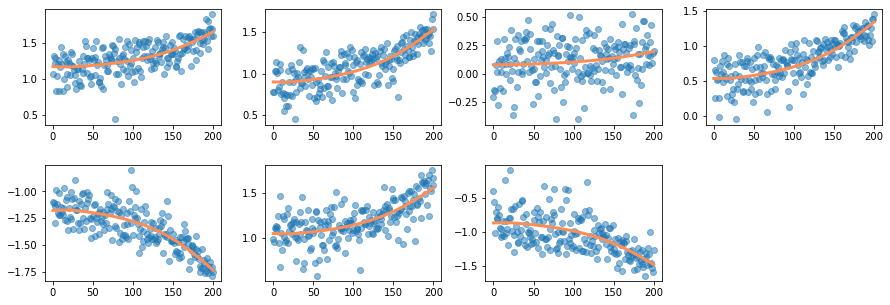

In [16]:
unit_index = 0
predict_sensors(net, T[unit_index], train_data[unit_index], unit_index)

In [17]:
lam, Th = 0.1, 0.70 # 大于Th的时间点被认为是异常点
valid_obv = []
    
for i in range(num_train):
    unit_i = selected_unit[i] 
    L = df_train[df_train['Unit'] == unit_i+1].iloc[:,2:].values
    tmp_n, q = lengths[i], 2
    tmp_Psi = Psi[:tmp_n]

    # 初始化
    H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(tmp_Psi.shape[1]))) @ tmp_Psi.T
    X = np.eye(H.shape[0]) - H


    Y = X @ L
    gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
    
    obv_index = []
    for i in range(num_sensors):
        obv_index.append(np.where(np.abs(gamma)[:,i]>0.7))
        
    valid_obv.append(np.delete(np.arange(gamma.shape[0]),np.unique(np.hstack(obv_index))))

In [20]:
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
# net.params = torch.load('LSTM-SVGD-Pre(40)-1.pth')

In [80]:
num_epochs, lr = 300, 0.001
batch_size, step_size = 1, 1e-6
loss_lt = train(net, lr, num_epochs, T, train_data, batch_size, model, step_size, valid_obv)

epoch:1/300
Loss: 0.04853547364473343
epoch:11/300
Loss: 0.04855369031429291
epoch:21/300
Loss: 0.04851943999528885
epoch:31/300
Loss: 0.04850976541638374
epoch:41/300
Loss: 0.048494912683963776
epoch:51/300
Loss: 0.04848294332623482
epoch:61/300
Loss: 0.04847227782011032
epoch:71/300
Loss: 0.04846101999282837
epoch:81/300
Loss: 0.048449449241161346
epoch:91/300
Loss: 0.048437584191560745
epoch:101/300
Loss: 0.04842546954751015
epoch:111/300
Loss: 0.04841315373778343
epoch:121/300
Loss: 0.048400670289993286
epoch:131/300
Loss: 0.04838806390762329
epoch:141/300
Loss: 0.04837535694241524
epoch:151/300
Loss: 0.04836258664727211
epoch:161/300
Loss: 0.0483497753739357
epoch:171/300
Loss: 0.0483369380235672
epoch:181/300
Loss: 0.0483241006731987
epoch:191/300
Loss: 0.04831128194928169
epoch:201/300
Loss: 0.04829849302768707
epoch:211/300
Loss: 0.048285745084285736
epoch:221/300
Loss: 0.04827307164669037
epoch:231/300
Loss: 0.048260465264320374
epoch:241/300
Loss: 0.048247940838336945
epoch:2

In [80]:
num_epochs, lr = 300, 0.001
batch_size, step_size = 1, 1e-6
loss_lt = train(net, lr, num_epochs, T, train_data, batch_size, model, step_size, valid_obv)

epoch:1/300
Loss: 0.0446895956993103
epoch:11/300
Loss: 0.04471614956855774
epoch:21/300
Loss: 0.044685058295726776
epoch:31/300
Loss: 0.044685665518045425
epoch:41/300
Loss: 0.044678203761577606
epoch:51/300
Loss: 0.044675201177597046
epoch:61/300
Loss: 0.04467213153839111
epoch:71/300
Loss: 0.04466897249221802
epoch:81/300
Loss: 0.04466560110449791
epoch:91/300
Loss: 0.044662121683359146
epoch:101/300
Loss: 0.044658489525318146
epoch:111/300
Loss: 0.04465449973940849
epoch:121/300
Loss: 0.04464935138821602
epoch:131/300
Loss: 0.044643327593803406
epoch:141/300
Loss: 0.044637054204940796
epoch:151/300
Loss: 0.0446309819817543
epoch:161/300
Loss: 0.04462505131959915
epoch:171/300
Loss: 0.044618863612413406
epoch:181/300
Loss: 0.04461265727877617
epoch:191/300
Loss: 0.044606491923332214
epoch:201/300
Loss: 0.04460049420595169
epoch:211/300
Loss: 0.044594619423151016
epoch:221/300
Loss: 0.04458872973918915
epoch:231/300
Loss: 0.04458296671509743
epoch:241/300
Loss: 0.04457700997591019
ep

In [73]:
torch.save(net.params, 'LSTM-SVGD-Pre(40)-2.pth')

In [95]:
# num_train = 20
t = [torch.tensor([i/500.0]) for i in range(500)]
Psi = get_H(t, net.params, num_hiddens).detach().numpy()

tmp_B = net.params[12].detach().numpy()
B_update = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    B_update[i] = tmp_B[i].T
    
Psi.shape, B_init.shape

((500, 3), (40, 7, 3))

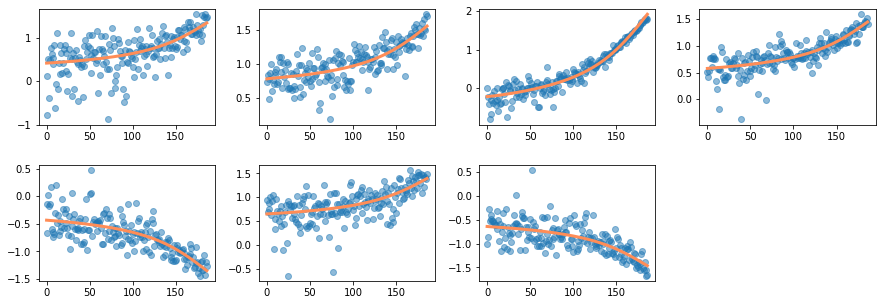

In [96]:
unit_index = 5
predict_sensors(net, T[unit_index], train_data[unit_index], unit_index)

In [97]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = B_update[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.09006513, 0.06465018, 0.02416872, 0.06463298, 0.06123177,
       0.0892324 , 0.08494993])

In [98]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = B_update[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5],cov_list[6])
# cov = np.cov(gamma.reshape(num_train,-1).T)
mu = B_update.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((21, 21), (21, 1))

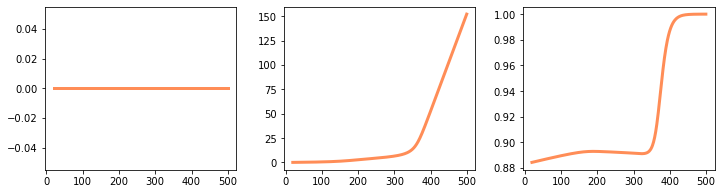

In [99]:
fig = plt.figure(figsize=(12,3))

for i in range(3):
    plt.subplot(1, 3, 1+i)
    tt = np.arange(Psi.shape[0])
    plt.plot(tt[20:], Psi[20:,i], color='#FF8D57', linewidth = 3)

plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
plt.show()

In [100]:
# num_train = 100

mu_i = np.zeros((num_train, 3*num_sensors,1)) 
cov_i = np.zeros((num_train,3*num_sensors,3*num_sensors))

for i in range(num_train):
    tmp_n = lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = train_data[i].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [101]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 25 # 超参数
inputs = np.zeros((K*num_train,2*N,num_sensors))

for i in range(num_train):
    M = lengths[i]
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
    
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
        
    for k in range(K):
        inputs[i*K+k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[t]
        
# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
# print(label.shape) (1,160)
labels = np.repeat(labels, K*num_train, axis=0)

inputs.shape, labels.shape

((1000, 160, 7), (1000, 160))

In [102]:
from sklearn.linear_model import LogisticRegression
X_train = inputs.reshape(-1,num_sensors)
Y_train = labels.reshape(-1,1)
X_train.shape, Y_train.shape

model = LogisticRegression(penalty="l2", C=0.01, solver="sag", max_iter=1000) #创建模型
model.fit(X_train, Y_train.ravel()) #训练

LogisticRegression(C=0.01, max_iter=1000, solver='sag')

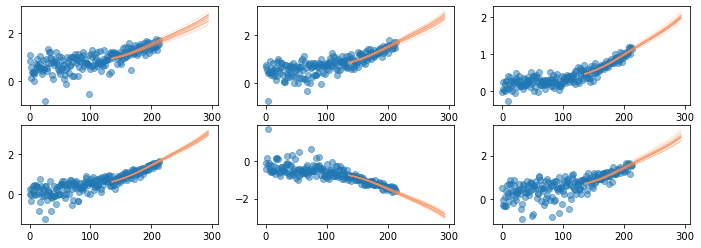

In [103]:
index = 10
sensor_data = train_data[index]

M = lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    for k in range(K):
        sensor_path = inputs[index*K + k]
        plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 0.2)

In [104]:
df_test = pd.read_excel('test_data.xlsx')
num_test = df_test['Unit'].max()      # 测试数据数量

test_data = []
test_lengths = []
for i in range(num_test):
    Y = np.array(df_test[df_test['Unit']==i+1].iloc[:,2:]) 
    test_data.append(Y)
    test_lengths.append(len(Y))

lam, Th = 0.1, 0.62

updated_data = []
for i in range(num_test):
    L = test_data[i]
    tmp_n, q = test_lengths[i], 2
    tmp_Psi = Psi[:tmp_n]
    
    # B = (inv(tmp_Psi.T @ tmp_Psi) @ tmp_Psi.T @ L).T

    # 初始化
    H = tmp_Psi @ inv(tmp_Psi.T @ tmp_Psi + 1e-6*np.diag(np.ones(3))) @ tmp_Psi.T
    X = np.eye(H.shape[0]) - H

    for epoch in range(5):
        Y = X @ L
        gamma = inv(X.T @ X + lam*np.eye(X.shape[0])) @ X.T @ Y
        R = np.zeros(gamma.shape[0])

        for j in range(gamma.shape[0]):
            tmp_gamma = gamma[j].reshape(1,-1)
            R[j] = tmp_gamma @ tmp_gamma.T

        # update
        L[np.where(R>Th)] = L[np.where(R>Th)] - gamma[np.where(R>Th)] # corrected
     
    updated_data.append(L)

In [105]:
mu_j = np.zeros((num_test, num_hiddens*num_sensors,1)) 
cov_j = np.zeros((num_test,num_hiddens*num_sensors,num_hiddens*num_sensors))

for i in range(num_test):
    tmp_n = test_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = updated_data[i].T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_j[i] = tmp_mu
    cov_j[i] = tmp_cov

mu_j.shape, cov_j.shape

((100, 21, 1), (100, 21, 21))

In [59]:
np.save('test_mu_svgd.npy',mu_j)
np.save('test_cov_svgd.npy',cov_j)

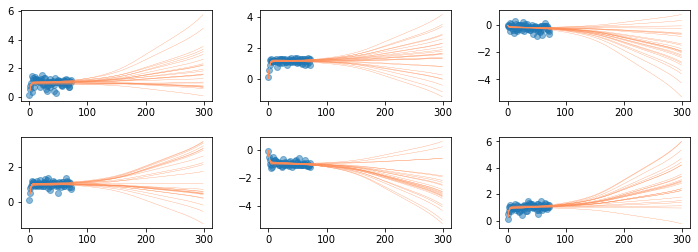

In [106]:
index, K, valid_len = 46, 25, 300
sensor_data = test_data[index]
tmp_Psi = Psi[:valid_len]
gamma_samples = np.random.multivariate_normal(mu_j[index].flatten(), cov_j[index], size=K)

fig = plt.figure(figsize=(12,4))

for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha = 0.5)
    for k in range(K):
        sensor_path = tmp_Psi @ gamma_samples[k].reshape(num_sensors,-1).T
        plt.plot(sensor_path[:,i], color='#FF8D57', linewidth=0.3)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.4)
plt.show()

In [35]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

def score(true_RUL, pred_RUL):
    d = pred_RUL - true_RUL
    n = len(true_RUL)
    score = np.zeros(n)
    for i in range(n):
        d_i = d[i]
        if d_i >= 0:
            score[i] = np.exp(d_i/10) - 1
        elif d_i < 0:
            score[i] = np.exp(-d_i/13) - 1
    return score.sum()

In [107]:
results1 = np.zeros(50)
results2 = np.zeros(50)
results3 = np.zeros(50)

for l in range(50):
    # 设置特征值
    K = 100 # 超参数
    X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
    for i in range(num_test):
        gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
        for k in range(K):
            X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T
            
    pred_RUL = np.zeros(num_test)

    for i in range(num_test):
        
        p = np.zeros((K, Psi.shape[0]))
        for k in range(K):
            x_i = X_test[i,k]
            p[k] = model.predict_proba(x_i)[:,1]
        pp = p.mean(axis=0)
        tmp_n = test_lengths[i]
        p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
        pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n
        
    df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
    df_RUL['pred_RUL'] = pred_RUL
    df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
    df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
    results1[l] = df_RUL['error'].mean()
    results2[l] = RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])
    results3[l] = score(df_RUL['true_RUL'], df_RUL['pred_RUL'])

In [108]:
results1.mean(), results1.std()

(0.06893225583302909, 0.0007208100304934668)

In [58]:
results2.mean(), results2.std()

(25.780031422226315, 0.17601099120174538)

In [34]:
results3.mean(), results3.std()

(525.595009614893, 21.811067953564944)

In [57]:
K = 25 # 超参数
X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
for i in range(num_test):
    gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
    for k in range(K):
        X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T

pred_RUL = np.zeros(num_test)

for i in range(num_test):

    p = np.zeros((K, Psi.shape[0]))
    for k in range(K):
        x_i = X_test[i,k]
        p[k] = model.predict_proba(x_i)[:,1]
    pp = p.mean(axis=0)
    tmp_n = test_lengths[i]
    p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
    pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n

df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
df_RUL['pred_RUL'] = pred_RUL
df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
df_RUL['error'].mean()

0.07332542352308459

In [45]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

In [58]:
RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])

20.38872237291979

In [78]:
df_RUL.to_excel('Result.xlsx')

In [ ]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 50 # 超参数

# 设置特征值-logistic regression
N, delta, K = 80, 1, 10 # 超参数
inputs = np.zeros((num_train,2*N,num_sensors))

for i in range(20):
    M = lengths[i]
    y_pred = Psi @ gamma[i].T
        
    M = lengths[i]
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
    
    inputs[i] = y_pred[t]
    
for i in range(20, num_train):
    M = lengths[i]
    y_pred = np.zeros((K,2*N,num_sensors))
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
        
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
        
    for k in range(K):
        y_pred[k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[t]
    
    inputs[i] = y_pred.mean(axis=0)

# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
labels = np.repeat(labels, num_train, axis=0)

np.save('inputs-svgd.npy', inputs)
np.save('labels-svgd.npy',labels)

inputs.shape, labels.shape